# Particle-COMETS: From dynamic FBA to spatial simulations with particles
Eran Agmon, University of Connecticut

This notebook is dedicated to developing a particle-COMETS simulation step by step using Vivarium.
Each section of this notebook incrementally adds layers to our model, illustrating the different computational methods and how they integrate.

In [31]:
import numpy as np
from spatio_flux import (
    SpatioFluxVivarium, # spatio-flux's customized Vivarium
    render_path
)

## Make a Vivarium
view available types and processes

In [32]:
# make a fresh vivarium
vi = SpatioFluxVivarium()

In [33]:
# view the available types
vi.get_types()

['',
 'current*length*time',
 'length^2/time',
 'time/length',
 'luminosity',
 'current*time/mass',
 'list',
 'current^2*time^4/length^3*mass',
 'mass/time^3',
 'mass/length^3',
 'any',
 'positive_float',
 'reaction',
 'length^3/mass*time^2',
 'enum',
 'map',
 'current',
 'boolean',
 'length^0_5*mass^0_5/time',
 'bounds',
 'wires',
 'process',
 'time^2/length',
 'length*time/mass',
 'mass/current*time^2',
 'current*time^2/length^2*mass',
 'mass^0_5/length^0_5*time',
 'length/time',
 'tuple',
 'length^2*mass/current*time^2',
 '/temperature*time',
 'length',
 'mass',
 'length/mass',
 'edge',
 'printing_unit',
 'tree',
 'length^0_5*mass^0_5',
 'luminosity/length^2',
 'length^2*mass/time',
 'length^2/time^2',
 'current*length^2',
 'particle',
 'mass/length*time^2',
 'integer',
 'union',
 'length^2*mass/current^2*time^3',
 'length^3',
 'string',
 'kinetics',
 'length^1_5*mass^0_5/time^2',
 'time',
 'substance/time',
 'length*mass/current*time^3',
 'number',
 'length*mass/current^2*time^2',


In [34]:
# view the available processes
vi.get_processes()

['DynamicFBA',
 'json-emitter',
 'Particles',
 'ram-emitter',
 'MinimalParticle',
 'console-emitter',
 'DiffusionAdvection',
 'composite']

## dFBA

Dynamic Flux Balance Analysis (dFBA) extends traditional Flux Balance Analysis (FBA) to model the dynamic behavior of metabolic networks over time, allowing for the simulation of growth and substrate consumption in a changing environment.

In [35]:
# inspect the DynamicFBA process config
vi.process_config('DynamicFBA')

{'model_file': 'string',
 'kinetic_params': 'map[tuple[float,float]]',
 'substrate_update_reactions': 'map[string]',
 'biomass_identifier': 'string',
 'bounds': 'map[bounds]'}

In [71]:
dfba_config  = vi.process_config('DynamicFBA', dataclass=True)  # TODO get dataclass to configure

Error finding process DynamicFBA: 'type_parameters'


In [72]:
vi.process_interface('DynamicFBA')  # TODO -- make this work

/Users/eranagmon/code/spatio-flux/venv/lib/python3.11/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

RuntimeError: The connection to the BioModels repository failed.

In [37]:
dfba_config = {
    "model_file": "textbook",
    "kinetic_params": {
        "glucose": (0.5, 1),
        "acetate": (0.5, 2)},
    "substrate_update_reactions": {
        "glucose": "EX_glc__D_e",
        "acetate": "EX_ac_e"},
    "biomass_identifier": "biomass",
    "bounds": {
        "EX_o2_e": {"lower": -2, "upper": None},
        "ATPM": {"lower": 1, "upper": 1}
    }
}

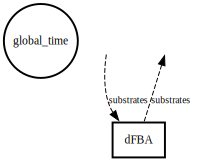

In [38]:
# make a fresh vivarium
v1 = SpatioFluxVivarium()

# add a dFBA process
v1.add_process(
    name="dFBA",
    process_id="DynamicFBA",
    config=dfba_config
)
v1.diagram(dpi='70')

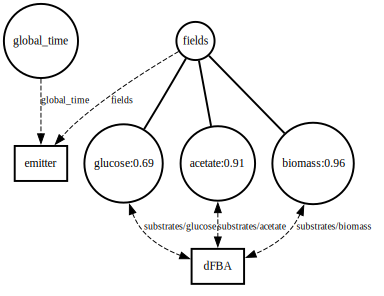

In [39]:
mol_ids = ["glucose", "acetate", "biomass"]

# add the molecular fields
for mol_id in mol_ids:
    v1.add_object(
        name=mol_id,
        path=['fields'],
        value=np.random.rand()
    )

v1.connect_process(
    name="dFBA",
    inputs={
            "substrates": {
                mol_id: ['fields', mol_id]
                for mol_id in mol_ids}
    },
    outputs={
            "substrates": {
                mol_id: ['fields', mol_id]
                for mol_id in mol_ids}
    }
)

# add an emitter to save results
v1.add_emitter()
v1.diagram(dpi='70', show_values=True)

In [40]:
v1.set_value(path=['fields', 'glucose'], value=10)
v1.set_value(path=['fields', 'biomass'], value=0.1)
field = v1.get_value(['fields'])
print(field)

{'glucose': 10, 'acetate': 0.9115998787447542, 'biomass': 0.1}


In [41]:
# save a file with the exact simulation state
v1.save(filename='dFBA_t0')

Saved file: out/dFBA_t0.json


In [42]:
# run the simulation
v1.run(interval=60)

In [65]:
# view the timeseries
v1.get_timeseries(as_dataframe=True)

,/global_time,/fields/glucose,/fields/acetate,/fields/biomass
0,0.0,10.000000,0.911600,0.100000
1,1.0,9.904762,0.923708,0.107943
2,2.0,9.802006,0.936684,0.116515
3,3.0,9.691146,0.950579,0.125766
4,4.0,9.571550,0.965444,0.135747
...,...,...,...,...
56,56.0,0.000000,0.000000,0.989340
57,57.0,0.000000,0.000000,0.989340
58,58.0,0.000000,0.000000,0.989340
59,59.0,0.000000,0.000000,0.989340


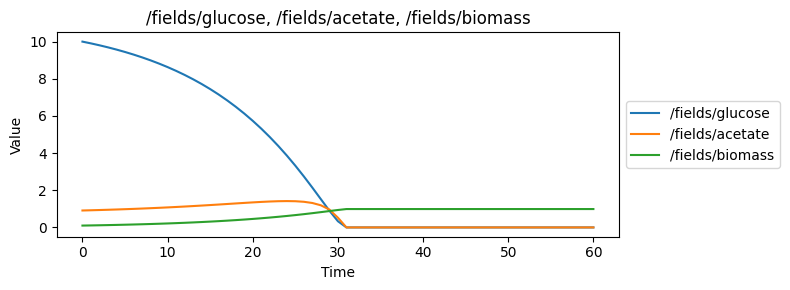

In [67]:
# plot the timeseries
v1.plot_timeseries(
    subplot_size=(8, 3),
    combined_vars=[
        [  # combine the variables into a single subplot
            '/fields/glucose',
            '/fields/acetate',
            '/fields/biomass'
        ]
    ]
)

## Spatial dFBA

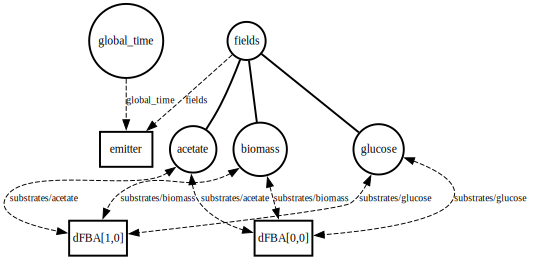

In [45]:
mol_ids = ["glucose", "acetate", "biomass"]
rows = 2
columns = 1

# make a fresh vivarium
v2 = SpatioFluxVivarium()
for mol_id in mol_ids:
    v2.add_object(
        name=mol_id,
        path=['fields'],
        value=np.random.rand(rows, columns)
    )

# add a dynamic FBA process at every location
for i in range(rows):
    for j in range(columns):
        dfba_name = f"dFBA[{i},{j}]"
        v2.add_process(
            name=dfba_name,
            process_id="DynamicFBA",
            config=dfba_config
        )
        v2.connect_process(
            name=dfba_name,
            inputs={"substrates": {
                        mol_id: ['fields', mol_id, i, j]
                        for mol_id in mol_ids}
            },
            outputs={"substrates": {
                        mol_id: ['fields', mol_id, i, j]
                        for mol_id in mol_ids}
            }
        )

# add an emitter to save results
v2.add_emitter()
v2.diagram(dpi='70')

In [46]:
# change some initial values
v2.merge_value(path=['fields', 'glucose', 0, 0], value=10.0)
v2.merge_value(path=['fields', 'biomass', 0, 0], value=0.1)
field = v2.get_value(['fields'])
print(field)

{'glucose': array([[10.        ],
       [ 0.14892073]]), 'acetate': array([[0.72426989],
       [0.28888776]]), 'biomass': array([[0.1       ],
       [0.08294909]])}


In [47]:
# run a simulation
v2.run(60)

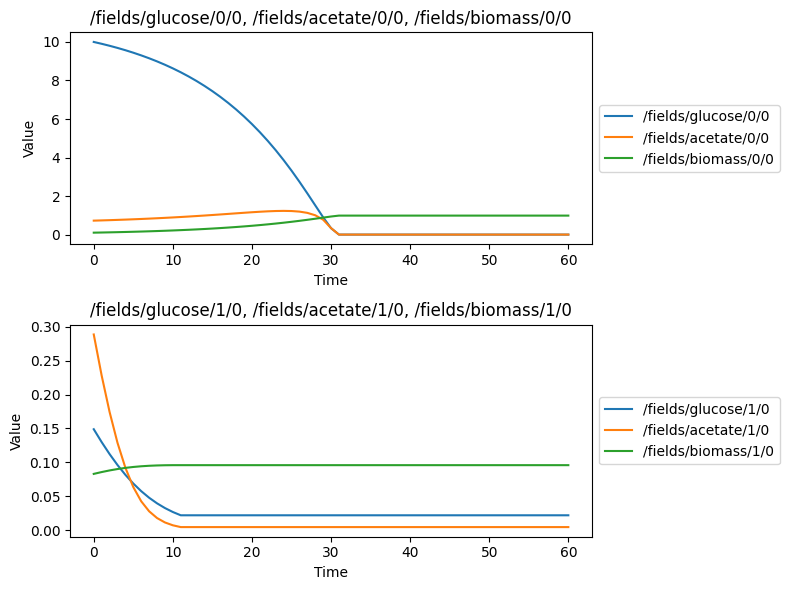

In [48]:
# get a list of all the paths so they can be plotted together in a single graph
all_paths = [
    [render_path(['fields', mol_id, i, j]) for mol_id in mol_ids]
    for i in range(rows)
    for j in range(columns)
]

# plot the timeseries
v2.plot_timeseries(
    subplot_size=(8, 3),
    combined_vars=all_paths
)

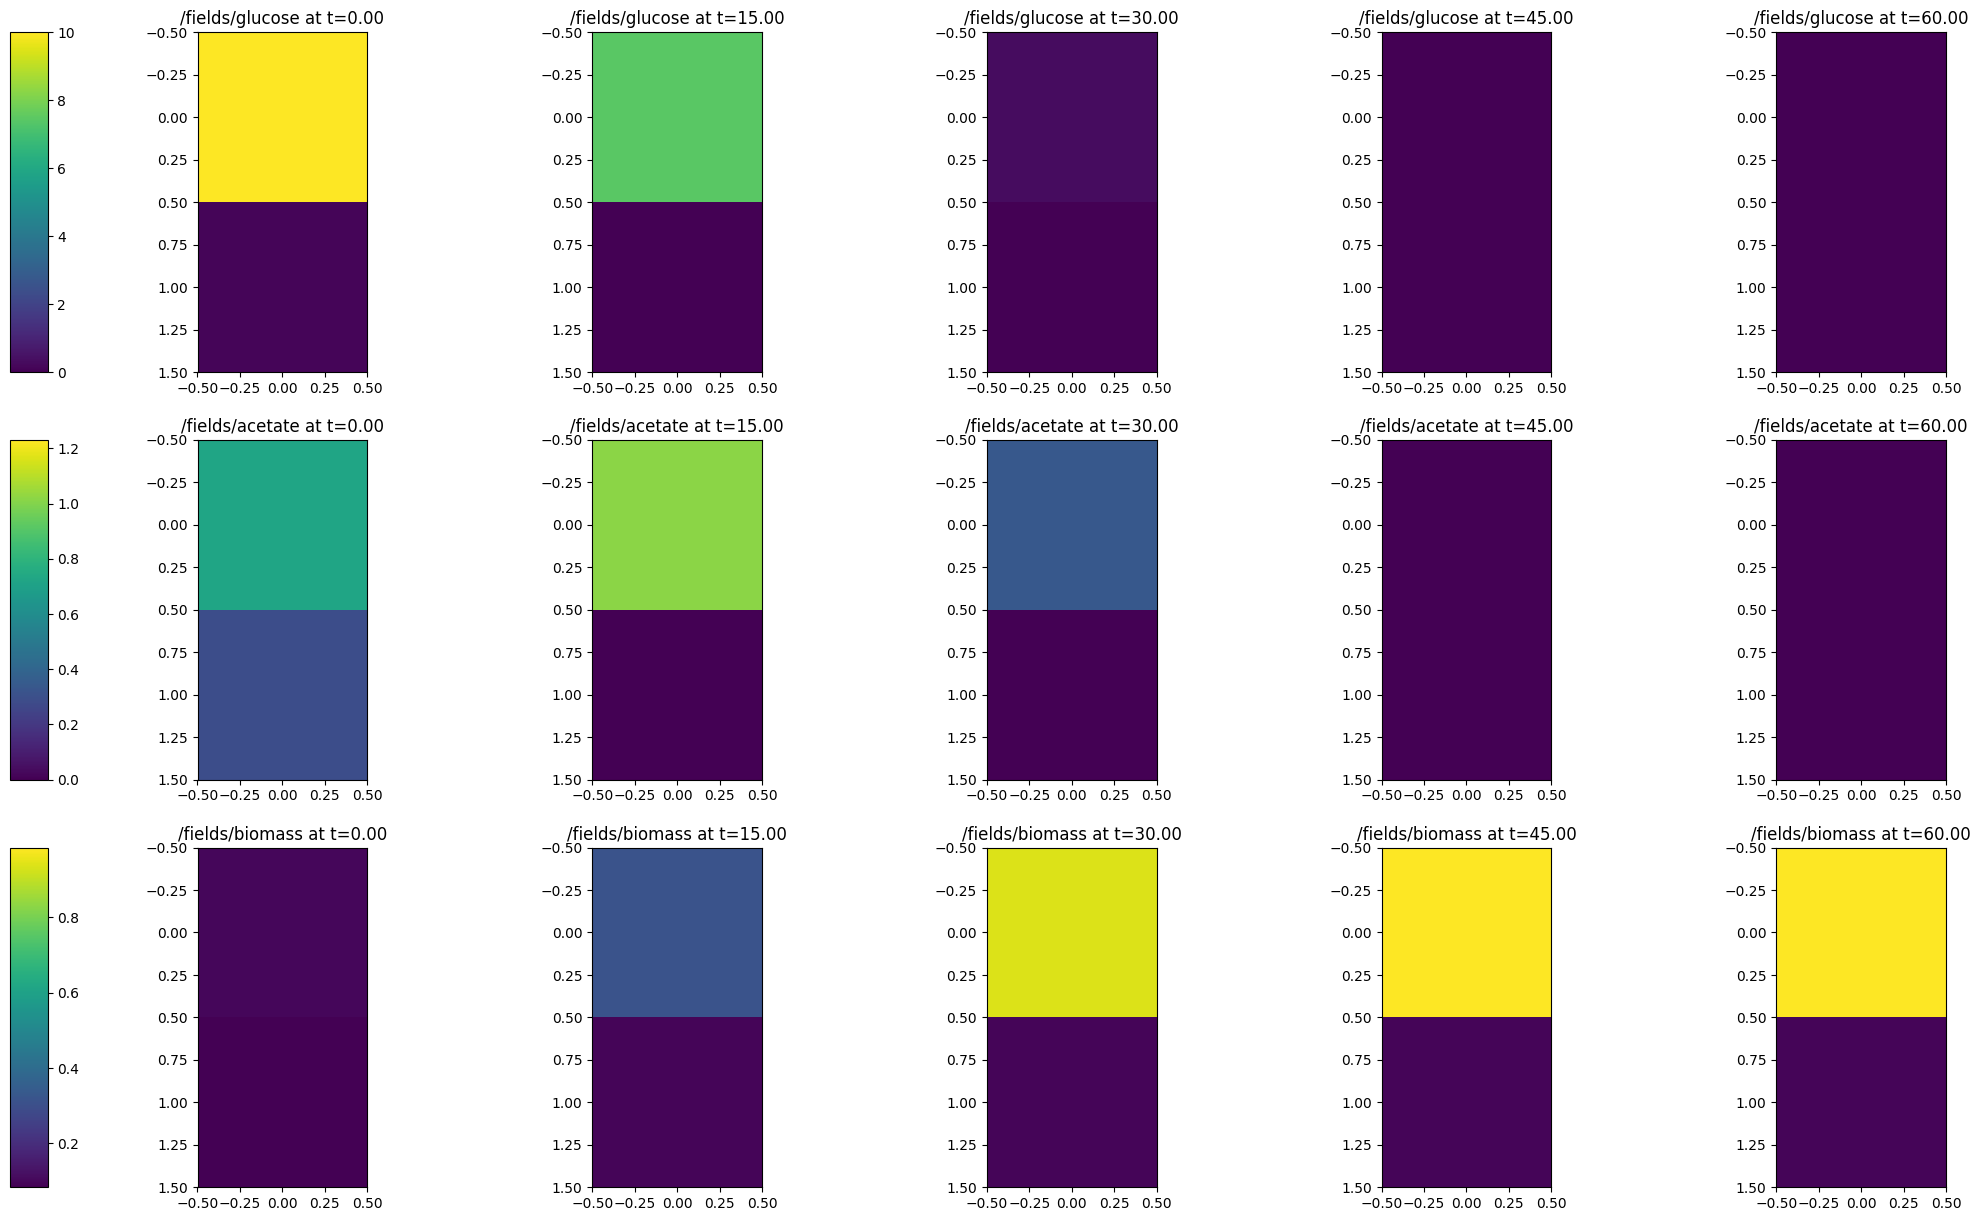

In [49]:
v2.plot_snapshots()

## Diffusion/Advection

This approach models the physical processes of diffusion and advection in two dimensions, providing a way to simulate how substances spread and are transported across a spatial domain, essential for understanding patterns of concentration over time and space.

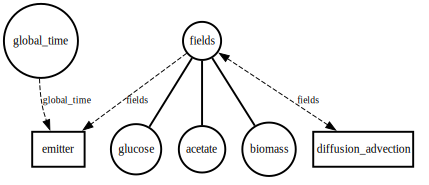

In [50]:
bounds = (10.0, 10.0)
n_bins = (10, 10)
mol_ids = [
    'glucose',
    'acetate',
    'biomass'
]
diffusion_rate = 1e-1
diffusion_dt = 1e-1
advection_coeffs = {
    'biomass': (0, -0.1)
}

# make a fresh Vivarium
v3 = SpatioFluxVivarium()

# add fields for all the molecules
for mol_id in mol_ids:
    v3.add_object(
        name=mol_id,
        path=['fields'],
        value=np.random.rand(n_bins[0], n_bins[1]))

# add a spatial diffusion advection process
v3.add_process(
    name='diffusion_advection',
    process_id='DiffusionAdvection',
    config={
       'n_bins': n_bins,
       'bounds': bounds,
       'default_diffusion_rate': diffusion_rate,
       'default_diffusion_dt': diffusion_dt,
       'advection_coeffs': advection_coeffs
    },
    inputs={'fields': ['fields']},
    outputs={'fields': ['fields']}
)

# add an emitter to save results
v3.add_emitter()
v3.diagram(dpi='70')

In [51]:
v3.run(60)


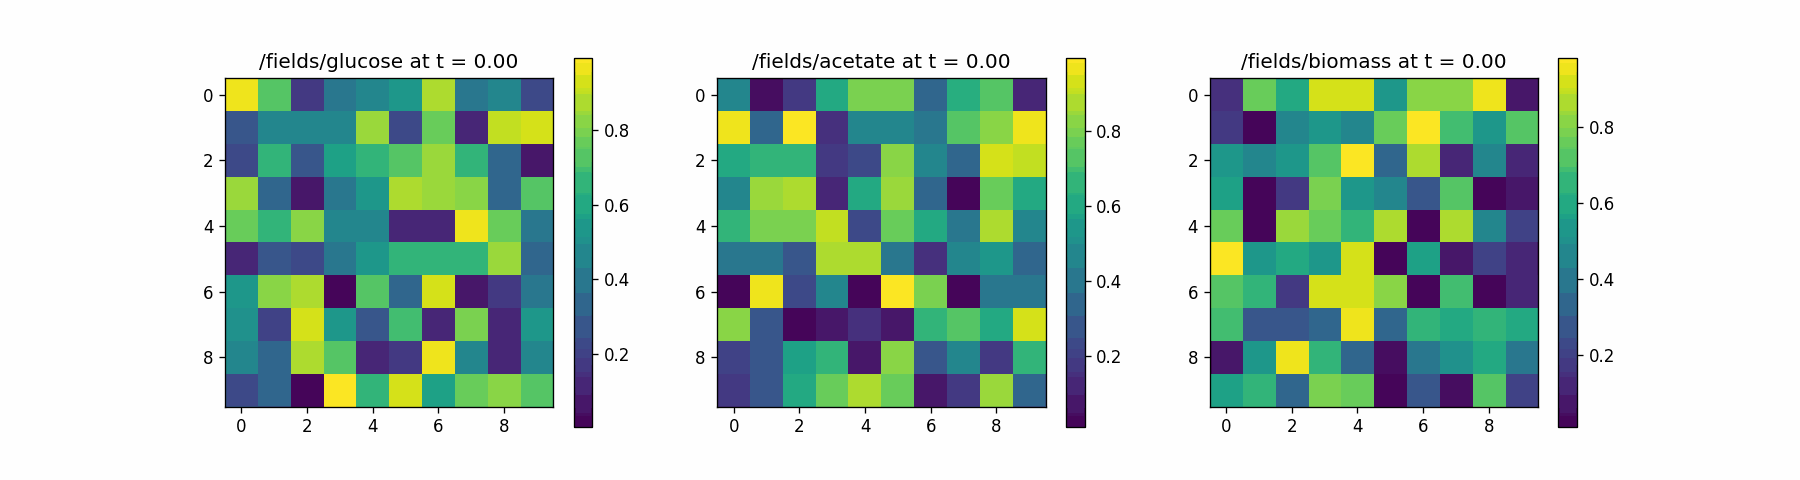

In [52]:
v3.show_video()

## COMETS (Computation Of Microbial Ecosystems in Time and Space)

COMETS combines dynamic FBA with spatially resolved physical processes (like diffusion and advection) to simulate the growth, metabolism, and interaction of microbial communities within a structured two-dimensional environment, capturing both biological and physical complexities.

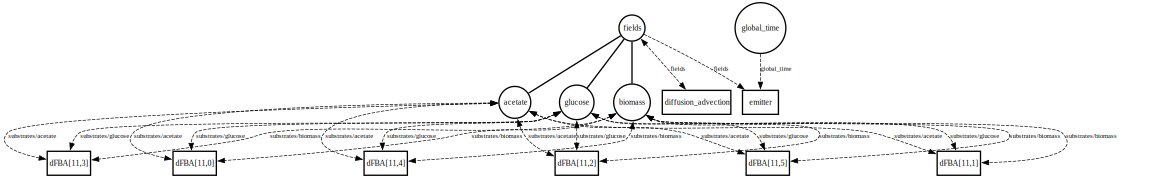

In [69]:
bounds = (20.0, 10.0)  # Bounds of the environment
n_bins = (12, 6)
mol_ids = ['glucose', 'acetate', 'biomass']
diffusion_rate = 1e-1
diffusion_dt = 1e-1
advection_coeffs = {
    'biomass': (0, 0.1)
}

# make a fresh vivarium
v4 = SpatioFluxVivarium()

# initialize the molecular fields
max_glc = 10
glc_field = np.random.rand(n_bins[0], n_bins[1]) * max_glc
acetate_field = np.zeros((n_bins[0], n_bins[1]))
biomass_field = np.zeros((n_bins[0], n_bins[1]))
biomass_field[0:int(1*n_bins[0]/5), int(2*n_bins[1]/5):int(3*n_bins[1]/5)] = 0.1  # place some biomass

v4.add_object(
    name='glucose',
    path=['fields'],
    value=glc_field
)
v4.add_object(
    name='biomass',
    path=['fields'],
    value=biomass_field
)
v4.add_object(
    name='acetate',
    path=['fields'],
    value=acetate_field
)

# add a diffusion/advection process
v4.add_process(
    name='diffusion_advection',
    process_id='DiffusionAdvection',
    config={
       'n_bins': n_bins,
       'bounds': bounds,
       'default_diffusion_rate': diffusion_rate,
       'default_diffusion_dt': diffusion_dt,
       'advection_coeffs': advection_coeffs
    },
    inputs={'fields': ['fields']},
    outputs={'fields': ['fields']}
)

# add a dynamic FBA process at every location
for i in range(n_bins[0]):
    for j in range(n_bins[1]):
        dfba_name = f"dFBA[{i},{j}]"
        v4.add_process(
            name=dfba_name,
            process_id="DynamicFBA",
            config=dfba_config
        )
        v4.connect_process(
            name=dfba_name,
            inputs={
                "substrates": {
                    mol_id: ['fields', mol_id, i, j]
                    for mol_id in mol_ids}
            },
            outputs={
                "substrates": {
                    mol_id: ['fields', mol_id, i, j]
                    for mol_id in mol_ids}
            }
        )

# add an emitter to save results
v4.add_emitter()
v4.diagram(
    dpi='70',
    remove_nodes=[f"/dFBA[{i},{j}]" for i in range(n_bins[0]-1) for j in range(n_bins[1])]
)

In [54]:
v4.run(60)


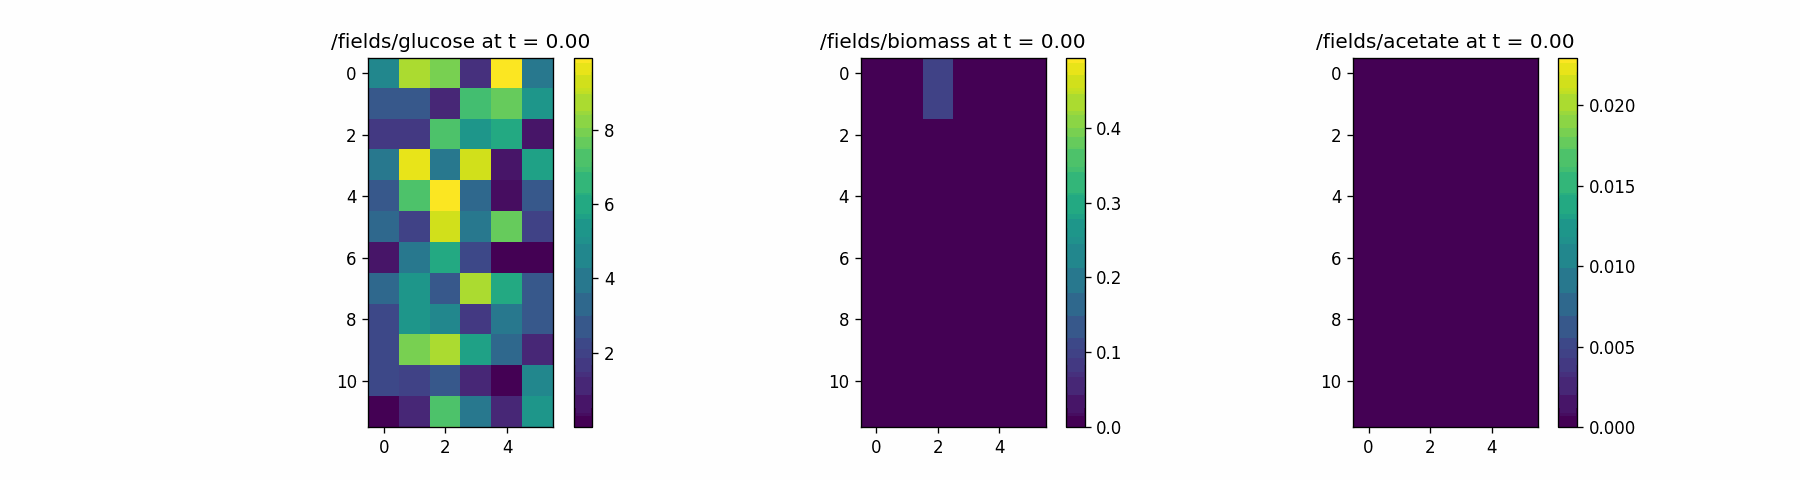

In [55]:
v4.show_video()

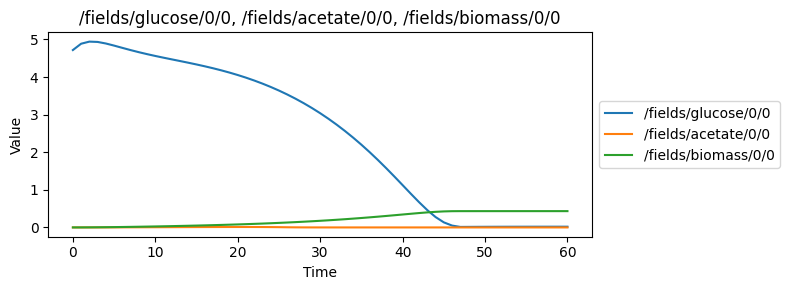

In [56]:
v4.plot_timeseries(
    subplot_size=(8, 3),
    query=[
        '/fields/glucose/0/0',
        '/fields/acetate/0/0',
        '/fields/biomass/0/0',
    ],
    combined_vars=[[
        '/fields/glucose/0/0',
        '/fields/acetate/0/0',
        '/fields/biomass/0/0',
    ]]
)

## Particles

In [57]:
import numpy as np
from spatio_flux import SpatioFluxVivarium

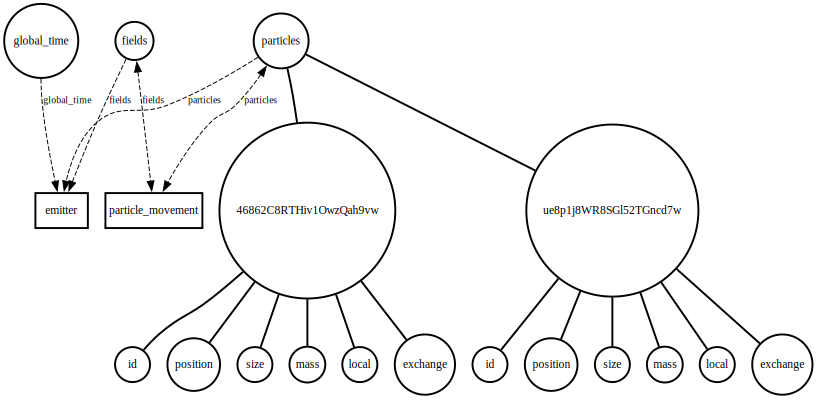

In [58]:
bounds = (10.0, 20.0)  # Bounds of the environment
n_bins = (20, 40)  # Number of bins in the x and y directions

v5 = SpatioFluxVivarium()

v5.add_process(
    name='particle_movement',
    process_id='Particles',
    config={
        'n_bins': n_bins,
        'bounds': bounds,
        'diffusion_rate': 0.1,
        'advection_rate': (0, -0.1),
        'add_probability': 0.4,
        'boundary_to_add': ['top']
    },
)
v5.connect_process(
    name='particle_movement',
    inputs={
        'fields': ['fields'],
        'particles': ['particles']
    },
    outputs={
        'fields': ['fields'],
        'particles': ['particles']
    }
)

v5.initialize_process(
    path='particle_movement',
    config={'n_particles': 2}
)

v5.add_emitter()
v5.diagram(dpi='70')

In [ ]:
v5.save('particle_movement')

In [59]:
v5.run(100)
v5_results = v5.get_results()

Saving GIF to species_distribution_with_particles.gif



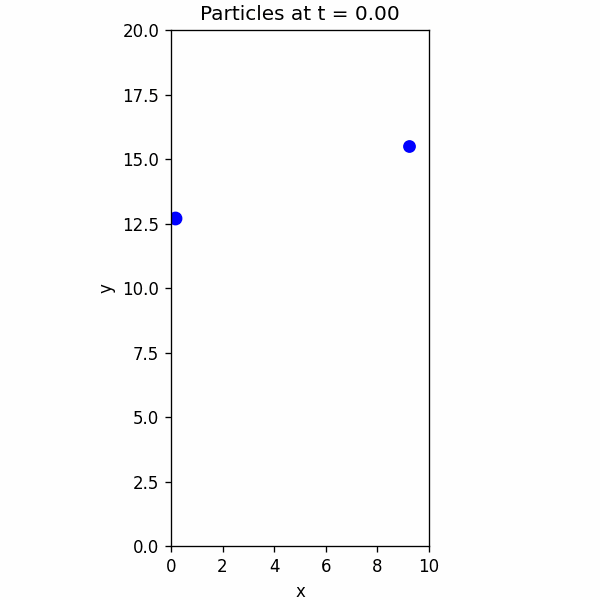

In [60]:
v5.plot_particles_snapshots(skip_frames=3)

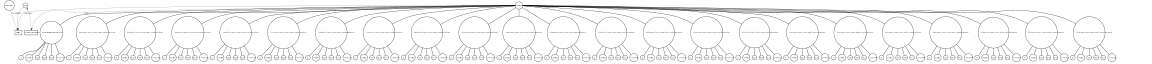

In [61]:
v5.diagram(dpi='70')

In [62]:
v5.save(filename='v5_post_run.json', outdir='out')

Saved file: out/v5_post_run.json


# Minimal particle process

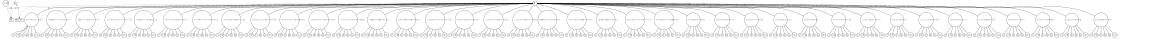

In [63]:
from spatio_flux.processes.particles import get_minimal_particle_composition

particle_schema = get_minimal_particle_composition(v5.core)

document = v5.make_document()
# document['state']['particles'] = {}
# # document['composition']['particles']
# document['composition'] = particle_schema
document['state']['global_time'] = 0.0

v6 = SpatioFluxVivarium(document=document)

v6.diagram(dpi='70')

In [64]:
v6.run(10)  # document is not getting deserialized?
v6_results = v6.get_results()

TypeError: can only concatenate str (not "numpy.float64") to str

In [78]:
from spatio_flux.processes.particles import get_minimal_particle_composition

bounds = (10.0, 20.0)  # Bounds of the environment
n_bins = (4, 8)  # Number of bins in the x and y directions

# same as before
v6 = SpatioFluxVivarium()
v6.add_process(
    name='particle_movement',
    process_id='Particles',
    config={
        'n_bins': n_bins,
        'bounds': bounds,
        'diffusion_rate': 0.1,
        'advection_rate': (0, -0.1),
        'add_probability': 0.4,
        'boundary_to_add': ['top']})
v6.connect_process(
    name='particle_movement',
    inputs={
        'fields': ['fields'],
        'particles': ['particles']},
    outputs={
        'fields': ['fields'],
        'particles': ['particles']})

# Here we go beyond the previous particle simulation
# add a minimal particle process into the schema
particle_schema = get_minimal_particle_composition(v6.core)
v6.set_schema('particles', particle_schema['particles'])

v6.initialize_process(
    path='particle_movement',
    config={'n_particles': 1})

v6.diagram(dpi='70')

RecursionError: maximum recursion depth exceeded in comparison

In [79]:
v6.run(10)
v6_results = v6.get_results()

RecursionError: maximum recursion depth exceeded in comparison

In [80]:
from spatio_flux.viz.plot import plot_species_distributions_with_particles_to_gif

# TODO -- integrate this method with vivarium
plot_species_distributions_with_particles_to_gif(
    v6_results,
    skip_frames=2,
    bounds=bounds
)

NameError: name 'v6_results' is not defined